# Crop Classification

The project focus three stages of crop cylce, please follow below link for know about the stages. 

[Crop details](https://docs.google.com/drawings/d/1oyH4NqZqckdJBXbudCC-5BtxOSA5LPmg3pojAGm8RP4/edit?usp=sharing)

Project focuses on 7 classes of crops which is divided into 4 different categories depending upon the respective crop cycle.


| crop      | crop_class |
| ----------- | ----------- |
| barley_w      | 1       |
| wheat_w   | 2        |
| rapeseed_w      | 3       |
| rye_w   | 4        |
| barley_s      | 5       |
| wheat_s   | 6        |
| oats_s   | 7       |



## Know the crop data

#### Import

In [1]:
import pandas as pd
import numpy as np
import rioxarray
import os
import geopandas as gpd
import rasterio
import shapely
import fiona
from tqdm import tqdm

import rasterio.mask
import sys
from pathlib import Path



from data_op import shapefile
from config import settings as st
from common import dictionary_utils
import data_op.shape_opr as so

In [2]:
crop_classes = pd.read_excel(os.path.join(st.data_directory,'crop_code/croptable_2020.xlsx'))

In [3]:
crop_classes

,Crop_nr,Name
0,1,Spring barley
1,2,Spring wheat
2,3,Spring oats
3,4,Mix of spring sown cereals
4,5,Maize for maturity
...,...,...
321,711,Green grain of winter triticale
322,900,Other crops
323,903,Light and open areas in wood
324,905,Other use on areas with schemes


In [9]:
crop_classes_list = np.unique(crop_classes.Crop_nr)
print(len(crop_classes_list))

326


Distinct crop classes and names for 7 crops, divided into 4 categories depending upon the respective crop cycle, 

**Categories**

| Index      | Months |
| ----------- | ----------- |
| 1      |  Jan-Mar      |
| 2   | Apr-Jun        |
| 3      | Jul-Sep       |
| 4   | Oct-Nov        |

**Category wise crop classes**

</br>
</br>

**1. Jan-Mar**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   706     | mid |
| wheat_w   | 707       | mid |
| rye_w      | 709,710      | mid |

</br>
</br>

**2. Apr-Jun**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     |   706     | mid |
| wheat_w   | 707       | mid |
| rye_w      | 709,710      | mid |
| barley_s   | 01,701      | planting and mid |
| wheat_s      | 02,06,702     | planting and mid  |
| oats_s      | 03,703    | planting and mid  |

</br>
</br>


**3. Jul-Sep**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     |   706,220     | mid and harvest |
| wheat_w   | 707,221       | mid and harvest|
| rye_w      | 222     | harvest |
| barley_s   | 701,210      | mid and harvest |
| wheat_s      | 702,211     | mid and harvest |
| oats_s      | 703,212    | mid and harvest  |

</br>
</br>
  

**4. Oct-Dec**

| crop      | Crop_nr |   cycle_stage      |
| ----------- | ----------- | ----------- |
|  barley_w     | 10    | planting|
| wheat_w   | 11,13      | planting|
| rapeseed_w      | 22     | planting |
| rye_w      | 14,15     | planting |
| barley_s   | 210      | harvest |
| wheat_s      | 211     | harvest |

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

Summmer and Winter crop categorisation

| Season      | crop |
| ----------- | ----------- |
| Winter      | barley_w, wheat_w, rapeseed_w, rye_w       |
| Summer/Spring   | barley_s,wheat_s,oats_s        |

</br>
</br>
</br>
</br>
</br>
</br>
</br>
</br>

**1. Jan-Mar**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid |
| wheat_w   | 11,13       | mid |
| rye_w      | 14,15      | mid |
| rapeseed_w      | 22     | mid |

**2. Apr-Jun**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid |
| wheat_w   | 11,13       | mid |
| rye_w      | 14,15      | mid |
| rapeseed_w      | 22     | mid |
| barley_s   | 01      | planting and mid  |
| wheat_s      | 02,06     | planting and mid |
| oats_s      | 03   | planting and mid |

**3. Jul-Sep**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | mid and harvest |
| wheat_w   | 11,13       | mid and harvesst|
| rye_w      | 14,15      | harvest |
| rapeseed_w      | 22     | harvest |
| barley_s   | 01     | mid and harvest |
| wheat_s      | 02,06     | mid and harvest |
| oats_s      | 03   | mid and harvest  |

**4. Oct-Dec**

| crop      | Crop_nr |   cycle_stage     |
| ----------- | ----------- | ----------- |
|  barley_w     |   10     | planting |
| wheat_w   | 11,13       | planting|
| rye_w      | 14,15      | planting |
| rapeseed_w      | 22     | planting |
| barley_s   | 01     |  harvest |
| wheat_s      | 02,06     | harvest |






## Prepare Shapefiles



In [3]:
# Create 4 shapefiles from 4 categorise 
path_raw = 'Raw_shape_files/Raw_downloaded_files'
shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(st.data_directory,path_raw,'Denmark_shape_2020/Marker_2020.shp'))
denmark_veg = shape_ex.import_shape()

#rename column 
denmark_veg.reset_index(drop=True, inplace=True)
denmark_veg = denmark_veg.rename(columns = {'Afgkode':'code'},errors='raise')
columns_to_be_remove= ['Marknr', 'IMK_areal', 'Journalnr', 'CVR', 'Afgroede', 'GB','Markblok', 'GBanmeldt']
denmark_veg = shape_ex.filter_shape_data(df = denmark_veg,column_names = columns_to_be_remove)

In [4]:
# category 1 jan-march
classes_for_cat_1 = {
    'barley_w': [10],
    'wheat_w': [11,13],
    'rye_w': [14,15],
    'rapeseed_w':[22]
    }
denmark_veg_cat_1 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_1,id_col = 'code',label_name='classes')

<AxesSubplot:>

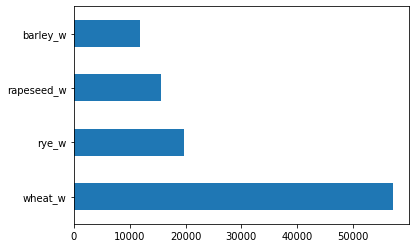

In [5]:
denmark_veg_cat_1['r_classes'].value_counts().plot(kind='barh')

In [8]:
print(denmark_veg_cat_1)
denmark_veg_cat_1.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','Jan_Mar.shp'))

        code                                           geometry r_classes  \
106     11.0  POLYGON ((705712.178 6093678.389, 705723.590 6...   wheat_w   
107     11.0  POLYGON ((705910.054 6091982.134, 705906.447 6...   wheat_w   
113     15.0  POLYGON ((705513.145 6095188.834, 705434.694 6...     rye_w   
114     15.0  POLYGON ((705579.495 6095314.224, 705582.219 6...     rye_w   
115     11.0  POLYGON ((705580.002 6091465.109, 705613.189 6...   wheat_w   
...      ...                                                ...       ...   
583645  11.0  POLYGON ((476791.084 6291213.102, 476791.436 6...   wheat_w   
583646  11.0  POLYGON ((476154.511 6292280.784, 476152.443 6...   wheat_w   
583648  10.0  POLYGON ((482149.487 6290435.470, 482137.496 6...  barley_w   
583649  10.0  POLYGON ((482232.214 6290475.882, 482234.754 6...  barley_w   
583650  11.0  POLYGON ((476741.079 6291510.861, 476735.513 6...   wheat_w   

        r_code  
106          2  
107          2  
113          3  
114    

<AxesSubplot:>

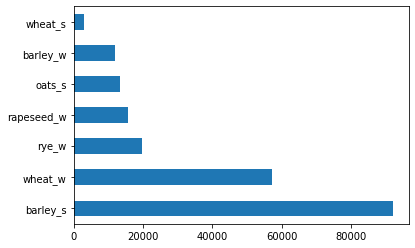

In [9]:
# category 2 Apr-jun and jul-sep
classes_for_cat_2 = {
    'barley_w': [10],
    'wheat_w': [11,13],
    'rye_w': [14,15],
    'rapeseed_w':[22],
    'barley_s': [1],
    'wheat_s' :[2,6],
    'oats_s':  [3]	
    }
denmark_veg_cat_2 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_2,id_col = 'code',label_name='classes')
denmark_veg_cat_2['r_classes'].value_counts().plot(kind='barh')


In [10]:
print(denmark_veg_cat_2)
denmark_veg_cat_2.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','Apr_Jun.shp'))
denmark_veg_cat_2.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','Jul_Sep.shp'))

        code                                           geometry r_classes  \
89       1.0  POLYGON ((542453.226 6236081.920, 542563.091 6...  barley_s   
91       1.0  POLYGON ((544238.662 6236095.382, 544238.651 6...  barley_s   
93       1.0  POLYGON ((543769.528 6236503.870, 543840.214 6...  barley_s   
94       1.0  POLYGON ((543712.587 6236609.939, 543703.430 6...  barley_s   
95       1.0  POLYGON ((704253.150 6093154.246, 704204.500 6...  barley_s   
...      ...                                                ...       ...   
583646  11.0  POLYGON ((476154.511 6292280.784, 476152.443 6...   wheat_w   
583647   1.0  POLYGON ((476472.707 6291933.559, 476610.051 6...  barley_s   
583648  10.0  POLYGON ((482149.487 6290435.470, 482137.496 6...  barley_w   
583649  10.0  POLYGON ((482232.214 6290475.882, 482234.754 6...  barley_w   
583650  11.0  POLYGON ((476741.079 6291510.861, 476735.513 6...   wheat_w   

        r_code  
89           5  
91           5  
93           5  
94     

<AxesSubplot:>

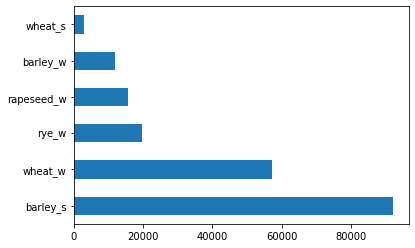

In [11]:
# category 3 Oct-Dec
classes_for_cat_3 = {
    'barley_w': [10],
    'wheat_w': [11,13],
    'rye_w': [14,15],
    'rapeseed_w':[22],
    'barley_s': [1],
    'wheat_s' :[2,6]	
    }
denmark_veg_cat_3 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_3,id_col = 'code',label_name='classes')
denmark_veg_cat_3['r_classes'].value_counts().plot(kind='barh')


In [12]:
denmark_veg_cat_3.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','Oct_Dec.shp'))

Summmer and Winter crop categorisation

| Season      | crop |
| ----------- | ----------- |
| Winter      | barley_w, wheat_w, rapeseed_w, rye_w       |
| Summer   | barley_s,wheat_s,oats_s        |

| Season      | crop |
| ----------- | ----------- |
| Winter      | 706,220,10,11,13,707,221,709,710,222,14,15,22      |
| Summer/Spring   | 01,701,210,211,702,02,06,03,703,212        |




<AxesSubplot:>

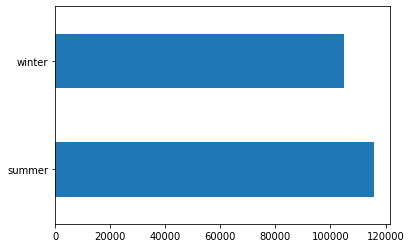

In [13]:
# category 3 Winter - Summer
classes_for_cat_4 = {
    'winter': [706,220,10,11,13,707,221,709,710,222,14,15,22],
    'summer': [1,701,210,211,702,2,6,3,703,212]	
    }
denmark_veg_cat_4 = shape_ex.prepare_labels(df = denmark_veg,class_dictionary = classes_for_cat_4,id_col = 'code',label_name='classes')
denmark_veg_cat_4['r_classes'].value_counts().plot(kind='barh')


In [14]:
print(denmark_veg_cat_4)
denmark_veg_cat_4.to_file(os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020','whole_summer_winter_2020.shp'))


         code                                           geometry r_classes  \
57      701.0  POLYGON ((452302.419 6183484.968, 452302.090 6...    summer   
58      701.0  POLYGON ((452302.419 6183484.968, 452289.190 6...    summer   
59      701.0  POLYGON ((452430.370 6183713.028, 452430.729 6...    summer   
89        1.0  POLYGON ((542453.226 6236081.920, 542563.091 6...    summer   
91        1.0  POLYGON ((544238.662 6236095.382, 544238.651 6...    summer   
...       ...                                                ...       ...   
583646   11.0  POLYGON ((476154.511 6292280.784, 476152.443 6...    winter   
583647    1.0  POLYGON ((476472.707 6291933.559, 476610.051 6...    summer   
583648   10.0  POLYGON ((482149.487 6290435.470, 482137.496 6...    winter   
583649   10.0  POLYGON ((482232.214 6290475.882, 482234.754 6...    winter   
583650   11.0  POLYGON ((476741.079 6291510.861, 476735.513 6...    winter   

        r_code  
57           2  
58           2  
59          

## Satellite Imagery Download

In [5]:
import geemap
import ee
import IPython

In [6]:

ee.Initialize()
Map = geemap.Map(center=[56.2639,9.5018], zoom=7)
Map

Map(center=[56.2639, 9.5018], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton…

In [7]:
denmark_geometry =ee.Geometry.Polygon(
        [[[8.06, 57.74],
          [10.62,57.74],
          [11.21, 57.31],
          [11.67, 56.74],
          [12.62,56.03],
          [12.64,55.81],
          [12.78,55.67],
          [12.79,55.64],
          [12.85,55.56],
          [12.57,54.94],
          [11.96, 54.55],
          [11.46, 54.60],
          [10.67,54.70],
          [9.937345,54.848469],
          [9.692023,54.828515],
          [9.636622,54.860250],
          [9.608859,54.890788],
          [9.485931,54.839107],
          [9.422113,54.830018],
          [9.343855,54.800103],
          [9.330371,54.804208],
          [9.329360,54.805617],
          [9.293550,54.808889],
          [9.292091,54.806168],
          [9.295584,54.803154],
          [9.250266,54.809606],
          [9.031632,54.876914],
          [8.778732,54.891528],
          [8.60156,54.910120],
          [8.50,55.05],
          [8.45,55.09],
          [8.06, 55.55]]], None, False);

In [9]:
# cloud precentage 2 for jan-sep and cloud percentage 10 for oct-dec
# Scale should be 10 as 10 m resolution for RGB in sentinel-2

# 5 images download.... 1. 2020, 2. Jan-Mar2020, 3. Apr-Jun2020 , 4. Jul-Sep2020, 5. Oct-Dec2020

dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(denmark_geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',2)) \
    .filterDate('2020-01-01', '2020-12-31') \
    .select(['B2', 'B3', 'B4']);
mosaic = dataset.mosaic().clip(denmark_geometry);

sentinel_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min':0, 
    'max':3000
    
}




In [10]:

Map.addLayer(mosaic, sentinel_vis , 'mosaic');
Map.centerObject(denmark_geometry);
image,request = mosaic._apply_visualization(sentinel_vis)


In [11]:
task_jul = ee.batch.Export.image.toDrive(image=image,  # an ee.Image object.
                                     region=denmark_geometry,  # an ee.Geometry object.
                                     description='denmark_export',
                                     folder='Fieldsegmentation_2020',
                                     fileNamePrefix='denmark',
                                     scale=10,
                                     crs='EPSG:4326',
                                     maxPixels = 1e12)
task_jul.start()

## Preprocess each shape files

In [4]:
reformatted_file_path = os.path.join(st.raw_shape_directory,'Reformatted','Denmark_shape_2020')
processed_file_path = os.path.join(st.data_directory,'Preprocessed_denamark_shape_files','Denmark_shape_2020')
for file in tqdm(os.listdir(reformatted_file_path)):
    file_type,filename = file.split('.')[1],file.split('.')[0]
    if file_type == 'shp':
        shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(reformatted_file_path,file))
        denmark_veg = shape_ex.import_shape()
        denmark_veg = shape_ex.explode(df = denmark_veg)
        denmark_veg = shape_ex.buffer_zero(denmark_veg)
        denmark_veg = denmark_veg.reset_index(drop=True)
        denmark_veg = denmark_veg.assign(fid=lambda _df: range(0, len(_df.index)))
        denmark_veg.to_file(os.path.join(processed_file_path,file))

  0%|          | 0/25 [00:00<?, ?it/s]
0it [00:00, ?it/s]
 16%|█▌        | 4/25 [01:14<06:32, 18.67s/it]
0it [00:00, ?it/s]
 20%|██        | 5/25 [02:35<11:39, 34.99s/it]
0it [00:00, ?it/s]
 52%|█████▏    | 13/25 [03:20<02:35, 12.97s/it]
0it [00:00, ?it/s]
 60%|██████    | 15/25 [04:49<03:16, 19.67s/it]
0it [00:00, ?it/s]
100%|██████████| 25/25 [06:17<00:00, 15.08s/it]


# Clip shape files for each tif(image files)

In [27]:
denmark_tif = os.path.join(st.data_directory,'Denmark_tif','2020')
processed_file_path = os.path.join(st.data_directory,'Preprocessed_denamark_shape_files','Denmark_shape_2020')
version = 0
for directory in tqdm(os.listdir(denmark_tif)):
    version = version+1
    shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(processed_file_path,str(directory)+'.shp'))
    denmark_veg = shape_ex.import_shape()
    denmark_veg = denmark_veg.to_crs("EPSG:4326")
    for file in tqdm(os.listdir(os.path.join(denmark_tif, directory))):

        with rasterio.open(os.path.join(denmark_tif,directory,file)) as src:
            raster_meta = src.meta
            raster_bounds = src.bounds

        

        filename = file.split('.')[0]


        df = shape_ex.clip(df = denmark_veg,clip_poly = shapely.geometry.box(*raster_bounds))

        df = df.assign(area_sqm = df.geometry.area)

        path = os.path.join(st.data_directory,'v_'+directory,'processed_shape_files')
        try:
            os.makedirs(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Creation of the directory %s Success" % path)
        df.to_file(os.path.join(path,str(filename)+'.shp'))

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_1_Apr_Jun/processed_shape_files Success



 50%|█████     | 1/2 [01:06<01:06, 66.54s/it]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_1_Apr_Jun/processed_shape_files failed



  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_2_whole_summer_winter_2020/processed_shape_files Success



 50%|█████     | 1/2 [01:11<01:11, 71.18s/it]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_2_whole_summer_winter_2020/processed_shape_files failed



  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_3_Jan_Mar/processed_shape_files Success



 50%|█████     | 1/2 [00:35<00:35, 35.06s/it]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_3_Jan_Mar/processed_shape_files failed



  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_4_Jul_Sep/processed_shape_files Success



 50%|█████     | 1/2 [01:08<01:08, 68.64s/it]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_4_Jul_Sep/processed_shape_files failed



  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_5_Oct_Dec/processed_shape_files Success



 50%|█████     | 1/2 [01:06<01:06, 66.53s/it]<ipython-input-27-eafd4e94cf88>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df = df.assign(area_sqm = df.geometry.area)


Creation of the directory /home/sami02/projects/thesis/Data/v_5_Oct_Dec/processed_shape_files failed



100%|██████████| 5/5 [09:45<00:00, 117.19s/it]


In [25]:
denmark_veg = denmark_veg.to_crs("EPSG:4326")

In [26]:
denmark_veg.geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Crop vector files into chips

In [2]:
image_size = 800

denmark_tif = os.path.join(st.data_directory,'Denmark_tif','2020')
processed_file_path = os.path.join(st.data_directory,'Preprocessed_denamark_shape_files','Denmark_shape_2020')



for directory in tqdm(os.listdir(denmark_tif)):
    count = 0
    file_name_image_id_count_dictionary = {}
    final_chip_dfs = {}
    version_path = os.path.join(st.data_directory,'v_'+directory)
    for file in tqdm(os.listdir(os.path.join(denmark_tif, directory))):
        with rasterio.open(os.path.join(denmark_tif,directory,file)) as src:
            raster_meta = src.meta
            raster_bounds = src.bounds
        filename = file.split('.')[0]
        
        shape_ex = shapefile.Shape_Extractor(shape_file = os.path.join(version_path,'processed_shape_files',str(filename)+'.shp'))
        denmark_veg = shape_ex.import_shape()
        prev = count
        chip_dfs,count = so.crop_vector_in_chips(df = denmark_veg,
                                             raster_width = raster_meta['width'],
                                             raster_height = raster_meta['height'],
                                             raster_transform = raster_meta['transform'],
                                             chip_width = image_size,
                                             chip_height=image_size,
                                             count = count,
                                             filename = filename,
                                             skip_partial_chips = True)
        
        path = os.path.join(version_path,'crop_chip_info')
        try:
            os.makedirs(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Creation of the directory %s Success" % path)
        
        chip_path = os.path.join(path,str(filename)+'.pickle')
        final_chip_dfs.update(chip_dfs)
        file_name_image_id_count_dictionary[filename] = list(range(prev, count))

        dictionary_utils.new_pickle(chip_path,chip_dfs)
        
    path = os.path.join(version_path,'final_crop_chip_info')
    try:
        os.makedirs(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
    else:
        print ("Creation of the directory %s Success" % path)
        
    dictionary_utils.new_pickle(os.path.join(path,'chip_dfs.pickle'),final_chip_dfs)
    dictionary_utils.new_pickle(os.path.join(path,'file_name_image_id_count_dictionary.pickle'),file_name_image_id_count_dictionary)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:01,  1.14s/it]

2it [00:02,  1.02s/it]

3it [00:03,  1.00it/s]

4it [00:03,  1.03it/s]

5it [00:04,  1.05it/s]

6it [00:05,  1.05it/s]

7it [00:06,  1.05it/s]

8it [00:07,  1.06it/s]

9it [00:08,  1.08it/s]

10it [00:09,  1.09it/s]

11it [00:10,  1.11it/s]

12it [00:11,  1.10it/s]

13it [00:12,  1.11it/s]

14it [00:13,  1.13it/s]

15it [00:13,  1.13it/s]

16it [00:14,  1.13it/s]

17it [00:15,  1.13it/s]

18it [00:16,  1.11it/s]

19it [00:17,  1.11it/s]

20it [00:18,  1.12it/s]

21it [00:19,  1.12it/s]

22it [00:20,  1.12it/s]

23it [00:21,  1.12it/s]

24it [00:21,  1.12it/s]

25it [00:22,  1.11it/s]

26it [00:23,  1.12it/s]

27it [00:24,  1.13it/s]

28it [00:25,  1.12it/s]

29it [00:26,  1.13it/s]

30it [00:27,  1.13it/s]

31it [00:28,  1.12it/s]

32it [00:29,  1.12it/s]

33it [00:29,  1.12it/s]

34it [00:30,  1.13it/s]

35it [00:31,  1.13it/s]

36it [00:32,  1.13it/s]

37it [00:33,  1.14it/s]

38it [00:34,  1.14it/s]



Creation of the directory /home/sami02/projects/thesis/Data/v_Apr_Jun/crop_chip_info Success



 50%|█████     | 1/2 [34:06<34:06, 2046.38s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Apr_Jun/crop_chip_info/denmark-0000000000-0000000000.pickle




0it [00:00, ?it/s]

1it [00:00,  4.56it/s]

2it [00:00,  4.81it/s]

3it [00:00,  4.94it/s]

4it [00:00,  4.99it/s]

5it [00:01,  5.05it/s]

6it [00:01,  5.00it/s]

7it [00:01,  5.00it/s]

8it [00:01,  5.01it/s]

9it [00:01,  4.31it/s]

10it [00:02,  4.49it/s]

11it [00:02,  4.66it/s]

12it [00:02,  4.77it/s]

13it [00:02,  4.86it/s]

14it [00:02,  4.93it/s]

15it [00:03,  4.92it/s]

16it [00:03,  4.93it/s]

17it [00:03,  4.96it/s]

18it [00:03,  4.97it/s]

19it [00:03,  5.00it/s]

20it [00:04,  4.97it/s]

21it [00:04,  4.99it/s]

22it [00:04,  5.02it/s]

23it [00:04,  5.05it/s]

24it [00:04,  4.74it/s]

25it [00:05,  4.42it/s]

26it [00:05,  4.45it/s]

27it [00:05,  3.58it/s]

28it [00:06,  2.99it/s]

29it [00:06,  2.68it/s]

30it [00:07,  2.60it/s]

31it [00:07,  2.59it/s]

32it [00:07,  2.60it/s]

33it [00:08,  2.74it/s]

34it [00:08,  2.56it/s]

35it [00:09,  2.40it/s]

36it [00:09,  2.69it/s]

37it [00:09,  3.14it/s]

38it [00:09,  3.54it/s]

39it [00:10,  3.60it/s]

40it [00:10,

Creation of the directory /home/sami02/projects/thesis/Data/v_Apr_Jun/crop_chip_info failed



100%|██████████| 2/2 [37:33<00:00, 1126.61s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Apr_Jun/crop_chip_info/denmark-0000000000-0000037888.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Apr_Jun/final_crop_chip_info Success



 20%|██        | 1/5 [37:40<2:30:42, 2260.61s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Apr_Jun/final_crop_chip_info/chip_dfs.pickle
Writing new pickle file... /home/sami02/projects/thesis/Data/v_Apr_Jun/final_crop_chip_info/file_name_image_id_count_dictionary.pickle



  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:01,  1.07s/it]

2it [00:01,  1.03it/s]

3it [00:02,  1.06it/s]

4it [00:03,  1.08it/s]

5it [00:04,  1.09it/s]

6it [00:05,  1.10it/s]

7it [00:06,  1.08it/s]

8it [00:07,  1.08it/s]

9it [00:08,  1.07it/s]

10it [00:09,  1.08it/s]

11it [00:10,  1.08it/s]

12it [00:11,  1.09it/s]

13it [00:12,  1.09it/s]

14it [00:13,  1.08it/s]

15it [00:13,  1.08it/s]

16it [00:14,  1.08it/s]

17it [00:15,  1.08it/s]

18it [00:16,  1.06it/s]

19it [00:17,  1.06it/s]

20it [00:18,  1.07it/s]

21it [00:19,  1.08it/s]

22it [00:20,  1.08it/s]

23it [00:21,  1.08it/s]

24it [00:22,  1.08it/s]

25it [00:23,  1.08it/s]

26it [00:24,  1.07it/s]

27it [00:25,  1.08it/s]

28it [00:26,  1.08it/s]

29it [00:26,  1.08it/s]

30it [00:27,  1.09it/s]

31it [00:28,  1.09it/s]

32it [00:29,  1.10it/s]

33it [00:30,  1.10it/s]

34it [00:31,  1.10it/s]

35it [00:32,  1.10it/s]

36it [00:33,  1.09it/s]

37it [00:34,  1.10it/s]

38it [00:35,  1.10it/s]


Creation of the directory /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/crop_chip_info Success



 50%|█████     | 1/2 [35:33<35:33, 2133.47s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/crop_chip_info/denmark-0000000000-0000000000.pickle




0it [00:00, ?it/s]

1it [00:00,  4.26it/s]

2it [00:00,  4.63it/s]

3it [00:00,  4.72it/s]

4it [00:00,  4.70it/s]

5it [00:01,  4.75it/s]

6it [00:01,  4.81it/s]

7it [00:01,  4.85it/s]

8it [00:01,  4.84it/s]

9it [00:01,  4.82it/s]

10it [00:02,  4.81it/s]

11it [00:02,  4.85it/s]

12it [00:02,  4.87it/s]

13it [00:02,  4.91it/s]

14it [00:02,  4.78it/s]

15it [00:03,  4.83it/s]

16it [00:03,  4.86it/s]

17it [00:03,  4.88it/s]

18it [00:03,  4.88it/s]

19it [00:03,  4.81it/s]

20it [00:04,  4.86it/s]

21it [00:04,  4.80it/s]

22it [00:04,  4.71it/s]

23it [00:04,  4.72it/s]

24it [00:05,  4.76it/s]

25it [00:05,  4.43it/s]

26it [00:05,  4.49it/s]

27it [00:05,  3.50it/s]

28it [00:06,  2.97it/s]

29it [00:06,  2.63it/s]

30it [00:07,  2.54it/s]

31it [00:07,  2.53it/s]

32it [00:08,  2.52it/s]

33it [00:08,  2.68it/s]

34it [00:08,  2.50it/s]

35it [00:09,  2.36it/s]

36it [00:09,  2.63it/s]

37it [00:09,  3.04it/s]

38it [00:10,  3.42it/s]

39it [00:10,  3.47it/s]

40it [00:10,

Creation of the directory /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/crop_chip_info failed



100%|██████████| 2/2 [39:04<00:00, 1172.36s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/crop_chip_info/denmark-0000000000-0000037888.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/final_crop_chip_info Success



 40%|████      | 2/5 [1:16:53<1:55:44, 2314.98s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/final_crop_chip_info/chip_dfs.pickle
Writing new pickle file... /home/sami02/projects/thesis/Data/v_whole_summer_winter_2020/final_crop_chip_info/file_name_image_id_count_dictionary.pickle



  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:00,  1.85it/s]

2it [00:01,  2.02it/s]

3it [00:01,  2.09it/s]

4it [00:01,  2.09it/s]

5it [00:02,  2.12it/s]

6it [00:02,  2.11it/s]

7it [00:03,  2.14it/s]

8it [00:03,  2.14it/s]

9it [00:04,  2.09it/s]

10it [00:04,  2.11it/s]

11it [00:05,  2.14it/s]

12it [00:05,  2.15it/s]

13it [00:06,  2.17it/s]

14it [00:06,  2.13it/s]

15it [00:07,  2.15it/s]

16it [00:07,  2.16it/s]

17it [00:08,  2.16it/s]

18it [00:08,  2.15it/s]

19it [00:08,  2.16it/s]

20it [00:09,  2.11it/s]

21it [00:09,  2.13it/s]

22it [00:10,  2.15it/s]

23it [00:10,  2.14it/s]

24it [00:11,  2.15it/s]

25it [00:11,  2.15it/s]

26it [00:12,  2.17it/s]

27it [00:12,  2.16it/s]

28it [00:13,  2.14it/s]

29it [00:13,  2.14it/s]

30it [00:14,  2.16it/s]

31it [00:14,  2.18it/s]

32it [00:14,  2.16it/s]

33it [00:15,  2.15it/s]

34it [00:15,  2.14it/s]

35it [00:16,  2.16it/s]

36it [00:16,  2.17it/s]

37it [00:17,  2.17it/s]

38it [00:17,  2.14it/s]


Creation of the directory /home/sami02/projects/thesis/Data/v_Jan_Mar/crop_chip_info Success



 50%|█████     | 1/2 [17:58<17:58, 1078.25s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jan_Mar/crop_chip_info/denmark-0000000000-0000000000.pickle




0it [00:00, ?it/s]

1it [00:00,  6.26it/s]

2it [00:00,  6.06it/s]

3it [00:00,  6.31it/s]

4it [00:00,  6.66it/s]

5it [00:00,  6.81it/s]

6it [00:00,  6.92it/s]

7it [00:01,  6.93it/s]

8it [00:01,  6.88it/s]

9it [00:01,  6.83it/s]

10it [00:01,  6.90it/s]

11it [00:01,  6.89it/s]

12it [00:01,  6.74it/s]

13it [00:01,  6.87it/s]

14it [00:02,  6.92it/s]

15it [00:02,  6.91it/s]

16it [00:02,  6.77it/s]

17it [00:02,  6.85it/s]

18it [00:02,  6.92it/s]

19it [00:02,  6.95it/s]

20it [00:02,  6.76it/s]

21it [00:03,  6.86it/s]

22it [00:03,  6.90it/s]

23it [00:03,  6.87it/s]

24it [00:03,  6.87it/s]

25it [00:03,  6.56it/s]

26it [00:03,  6.58it/s]

27it [00:04,  5.39it/s]

28it [00:04,  4.79it/s]

29it [00:04,  4.31it/s]

30it [00:04,  4.07it/s]

31it [00:05,  4.08it/s]

32it [00:05,  3.92it/s]

33it [00:05,  4.21it/s]

34it [00:05,  3.85it/s]

35it [00:06,  3.59it/s]

36it [00:06,  3.98it/s]

37it [00:06,  4.60it/s]

38it [00:06,  5.07it/s]

39it [00:06,  5.18it/s]

40it [00:07,

Creation of the directory /home/sami02/projects/thesis/Data/v_Jan_Mar/crop_chip_info failed



100%|██████████| 2/2 [20:20<00:00, 610.26s/it] 

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jan_Mar/crop_chip_info/denmark-0000000000-0000037888.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Jan_Mar/final_crop_chip_info Success



 60%|██████    | 3/5 [1:37:18<1:00:34, 1817.34s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jan_Mar/final_crop_chip_info/chip_dfs.pickle
Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jan_Mar/final_crop_chip_info/file_name_image_id_count_dictionary.pickle



  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:01,  1.00s/it]

2it [00:01,  1.08it/s]

3it [00:02,  1.10it/s]

4it [00:03,  1.12it/s]

5it [00:04,  1.12it/s]

6it [00:05,  1.12it/s]

7it [00:06,  1.13it/s]

8it [00:07,  1.14it/s]

9it [00:08,  1.14it/s]

10it [00:08,  1.13it/s]

11it [00:09,  1.14it/s]

12it [00:10,  1.14it/s]

13it [00:11,  1.11it/s]

14it [00:12,  1.11it/s]

15it [00:13,  1.12it/s]

16it [00:14,  1.11it/s]

17it [00:15,  1.11it/s]

18it [00:16,  1.10it/s]

19it [00:17,  1.11it/s]

20it [00:17,  1.09it/s]

21it [00:18,  1.10it/s]

22it [00:19,  1.11it/s]

23it [00:20,  1.11it/s]

24it [00:21,  1.12it/s]

25it [00:22,  1.13it/s]

26it [00:23,  1.14it/s]

27it [00:24,  1.14it/s]

28it [00:25,  1.14it/s]

29it [00:25,  1.14it/s]

30it [00:26,  1.14it/s]

31it [00:27,  1.14it/s]

32it [00:28,  1.14it/s]

33it [00:29,  1.14it/s]

34it [00:30,  1.14it/s]

35it [00:31,  1.14it/s]

36it [00:32,  1.14it/s]

37it [00:32,  1.14it/s]

38it [00:33,  1.14it/s]


Creation of the directory /home/sami02/projects/thesis/Data/v_Jul_Sep/crop_chip_info Success



 50%|█████     | 1/2 [34:08<34:08, 2048.78s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jul_Sep/crop_chip_info/denmark-0000000000-0000000000.pickle




0it [00:00, ?it/s]

1it [00:00,  4.24it/s]

2it [00:00,  4.66it/s]

3it [00:00,  4.74it/s]

4it [00:00,  4.76it/s]

5it [00:01,  4.85it/s]

6it [00:01,  4.91it/s]

7it [00:01,  4.92it/s]

8it [00:01,  4.87it/s]

9it [00:01,  4.90it/s]

10it [00:02,  4.82it/s]

11it [00:02,  4.84it/s]

12it [00:02,  4.88it/s]

13it [00:02,  4.80it/s]

14it [00:02,  4.85it/s]

15it [00:03,  4.87it/s]

16it [00:03,  4.89it/s]

17it [00:03,  4.92it/s]

18it [00:03,  4.82it/s]

19it [00:03,  4.87it/s]

20it [00:04,  4.90it/s]

21it [00:04,  4.87it/s]

22it [00:04,  4.78it/s]

23it [00:04,  4.76it/s]

24it [00:04,  4.83it/s]

25it [00:05,  4.54it/s]

26it [00:05,  4.57it/s]

27it [00:05,  3.61it/s]

28it [00:06,  3.03it/s]

29it [00:06,  2.66it/s]

30it [00:07,  2.57it/s]

31it [00:07,  2.54it/s]

32it [00:08,  2.54it/s]

33it [00:08,  2.70it/s]

34it [00:08,  2.50it/s]

35it [00:09,  2.37it/s]

36it [00:09,  2.65it/s]

37it [00:09,  3.07it/s]

38it [00:09,  3.49it/s]

39it [00:10,  3.57it/s]

40it [00:10,

Creation of the directory /home/sami02/projects/thesis/Data/v_Jul_Sep/crop_chip_info failed



100%|██████████| 2/2 [37:39<00:00, 1129.83s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jul_Sep/crop_chip_info/denmark-0000000000-0000037888.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Jul_Sep/final_crop_chip_info Success



 80%|████████  | 4/5 [2:15:06<33:15, 1995.02s/it]  

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jul_Sep/final_crop_chip_info/chip_dfs.pickle
Writing new pickle file... /home/sami02/projects/thesis/Data/v_Jul_Sep/final_crop_chip_info/file_name_image_id_count_dictionary.pickle



  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:00,  1.04it/s]

2it [00:01,  1.14it/s]

3it [00:02,  1.17it/s]

4it [00:03,  1.19it/s]

5it [00:04,  1.21it/s]

6it [00:05,  1.21it/s]

7it [00:05,  1.21it/s]

8it [00:06,  1.21it/s]

9it [00:07,  1.21it/s]

10it [00:08,  1.21it/s]

11it [00:09,  1.18it/s]

12it [00:10,  1.19it/s]

13it [00:10,  1.17it/s]

14it [00:11,  1.18it/s]

15it [00:12,  1.19it/s]

16it [00:13,  1.19it/s]

17it [00:14,  1.19it/s]

18it [00:15,  1.17it/s]

19it [00:16,  1.17it/s]

20it [00:16,  1.18it/s]

21it [00:17,  1.19it/s]

22it [00:18,  1.19it/s]

23it [00:19,  1.19it/s]

24it [00:20,  1.19it/s]

25it [00:21,  1.20it/s]

26it [00:21,  1.18it/s]

27it [00:22,  1.19it/s]

28it [00:23,  1.19it/s]

29it [00:24,  1.20it/s]

30it [00:25,  1.21it/s]

31it [00:26,  1.20it/s]

32it [00:26,  1.20it/s]

33it [00:27,  1.21it/s]

34it [00:28,  1.21it/s]

35it [00:29,  1.21it/s]

36it [00:30,  1.21it/s]

37it [00:31,  1.21it/s]

38it [00:31,  1.21it/s]


Creation of the directory /home/sami02/projects/thesis/Data/v_Oct_Dec/crop_chip_info Success



 50%|█████     | 1/2 [32:09<32:09, 1929.03s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Oct_Dec/crop_chip_info/denmark-0000000000-0000000000.pickle




0it [00:00, ?it/s]

1it [00:00,  4.15it/s]

2it [00:00,  4.60it/s]

3it [00:00,  4.75it/s]

4it [00:00,  4.82it/s]

5it [00:01,  4.91it/s]

6it [00:01,  4.95it/s]

7it [00:01,  5.00it/s]

8it [00:01,  5.03it/s]

9it [00:01,  5.00it/s]

10it [00:02,  4.81it/s]

11it [00:02,  4.85it/s]

12it [00:02,  4.83it/s]

13it [00:02,  4.89it/s]

14it [00:02,  4.90it/s]

15it [00:03,  4.78it/s]

16it [00:03,  4.72it/s]

17it [00:03,  4.64it/s]

18it [00:03,  4.76it/s]

19it [00:03,  4.81it/s]

20it [00:04,  4.87it/s]

21it [00:04,  4.70it/s]

22it [00:04,  4.78it/s]

23it [00:04,  4.87it/s]

24it [00:04,  4.86it/s]

25it [00:05,  4.56it/s]

26it [00:05,  4.63it/s]

27it [00:05,  3.63it/s]

28it [00:06,  3.06it/s]

29it [00:06,  2.75it/s]

30it [00:07,  2.64it/s]

31it [00:07,  2.60it/s]

32it [00:07,  2.57it/s]

33it [00:08,  2.74it/s]

34it [00:08,  2.57it/s]

35it [00:09,  2.37it/s]

36it [00:09,  2.67it/s]

37it [00:09,  3.10it/s]

38it [00:09,  3.46it/s]

39it [00:10,  3.56it/s]

40it [00:10,

Creation of the directory /home/sami02/projects/thesis/Data/v_Oct_Dec/crop_chip_info failed



100%|██████████| 2/2 [35:35<00:00, 1067.56s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Oct_Dec/crop_chip_info/denmark-0000000000-0000037888.pickle
Creation of the directory /home/sami02/projects/thesis/Data/v_Oct_Dec/final_crop_chip_info Success



100%|██████████| 5/5 [2:50:49<00:00, 2049.83s/it]

Writing new pickle file... /home/sami02/projects/thesis/Data/v_Oct_Dec/final_crop_chip_info/chip_dfs.pickle
Writing new pickle file... /home/sami02/projects/thesis/Data/v_Oct_Dec/final_crop_chip_info/file_name_image_id_count_dictionary.pickle


## Crop Raster Images into chips as did for Vector

In [ ]:
for directory in tqdm(os.listdir(denmark_tif)):
    version_path = os.path.join(st.data_directory,'v_'+directory)
    for file in tqdm(os.listdir(os.path.join(denmark_tif, directory))):
        filename = file.split('.')[0]
        chip_dfsss = file_name_image_id_count_dictionary[filename]
        chip_windows={}
        raster_image_max = 2200 ## Value used while extracting the sentinel-2 image
        for chip_no in chip_dfsss:
            chip_name = f'COCO_train2021_000000{100000 + chip_no}'
            chip_windows.update({chip_name:final_chip_dfs[chip_name]['chip_window']})
        stats = rf.cut_chip_images(inpath_raster = os.path.join(st.denmark_tif_directory,file),
                      outpath_chipfolder = os.path.join(st.crop_images_output_path),
                      chip_names = chip_windows.keys(),
                      chip_windows = chip_windows.values(),
                      raster_image_range = raster_image_max)